# Classifying languages with a character-level RNN

In [108]:
import glob
import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

## Reading data, analysis

In [109]:
words_by_lang = dict()

for filename in glob.glob('./data/common-words/*.txt'):
    lang = os.path.splitext(os.path.basename(filename))[0]
    words = open(filename).read().strip().split('\n')
    words_by_lang[lang] = words
    
langs = list(words_by_lang.keys())
n_langs = len(langs)

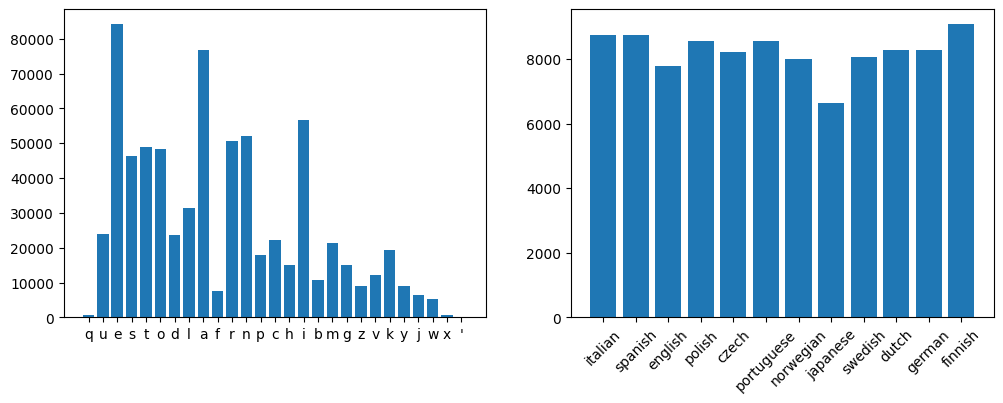

In [135]:
from functools import reduce
import string

char_dist = dict()

for char in reduce(lambda a, b: a + ''.join(b), words_by_lang.values(), ''):
    char_dist[char] = char_dist.get(char, 0) + 1

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12,4)
ax1.bar(char_dist.keys(), char_dist.values())
ax2.bar(langs, [len(words_by_lang[l]) for l in langs])
plt.xticks(rotation=45)
plt.show()

## Preparing the network

In [111]:
n_chars = len(char_dist)
all_chars = string.ascii_lowercase + "'"

def word_to_one_hot_tensor(word):
	def char_to_index(char):
		return all_chars.find(char)
	
	tensor = torch.zeros(len(word), 1, n_chars) # why another dim? as batch?

	for i, c in enumerate(word):
		tensor[i][0][char_to_index(c)] = 1

	return tensor

print(word_to_one_hot_tensor("abz'"))
print(word_to_one_hot_tensor("abz'").size())

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]])
torch.Size([4, 1, 27])


In [112]:
class RNN(nn.Module):
	def __init__(self, input_size, hidden_size, output_size):
		super(RNN, self).__init__()

		self.hidden_size = hidden_size

		self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
		self.h2o = nn.Linear(hidden_size, output_size)
		self.softmax = nn.LogSoftmax(dim=1)

	def forward(self, input, hidden):
		combined = torch.cat((input, hidden), dim=1)
		hidden = self.i2h(combined)
		output = self.h2o(hidden)
		output = self.softmax(output)
		return output, hidden
	
	def initHidden(self):
		return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_chars, n_hidden, n_langs)

In [113]:
def lang_from_output(output):
    top_w, top_i = output.topk(1)
    lang_i = top_i[0].item()
    return langs[lang_i], lang_i

inp = word_to_one_hot_tensor('slowo')
hidden = rnn.initHidden()

out, next_hidden = rnn(inp[0], hidden)
print(out)
print(lang_from_output(out))

tensor([[-2.4731, -2.5119, -2.4167, -2.5275, -2.4635, -2.4075, -2.4219, -2.6056,
         -2.5256, -2.5683, -2.3776, -2.5479]], grad_fn=<LogSoftmaxBackward0>)
('german', 10)


In [114]:
import random

def random_training_example():
	lang = random.choice(langs)
	word = random.choice(words_by_lang[lang])

	lang_tensor = torch.tensor([langs.index(lang)], dtype=torch.long)
	word_tensor = word_to_one_hot_tensor(word)

	return lang, word, lang_tensor, word_tensor

In [115]:
def train(rnn, device, criterion, opt, lang_tensor, word_tensor):
	hidden = rnn.initHidden().to(device)
	lang_tensor, word_tensor = lang_tensor.to(device), word_tensor.to(device)

	opt.zero_grad()

	for i in range(word_tensor.size()[0]):
		out, hidden = rnn(word_tensor[i], hidden)

	loss = criterion(out, lang_tensor)
	loss.backward()
	opt.step()

	return out, loss.item()

In [116]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f'CUDA enabled: {use_cuda}')

learning_rate = 0.005
criterion = nn.NLLLoss()
rnn = RNN(n_chars, n_hidden, n_langs)
rnn = rnn.to(device)
opt = optim.SGD(rnn.parameters(), lr=learning_rate)

n_iters = 100000
check_every = 5000

current_loss = 0
all_losses = []

for i in range(1, n_iters + 1):
    lang, word, lang_tensor, word_tensor = random_training_example()
    out, loss = train(rnn, device, criterion, opt, lang_tensor, word_tensor)
    current_loss += loss

    if i % check_every == 0:
        guess, guess_i = lang_from_output(out)
        is_correct = '✓' if guess == lang else f'✗ ({lang})'
        print('%d %d%% %.4f %s / %s %s' % (i, i / n_iters * 100, loss, word, guess, is_correct))

        all_losses.append(current_loss / check_every)
        current_loss = 0

CUDA enabled: True
5000 5% 2.4194 begavad / spanish ✗ (swedish)
10000 10% 2.8700 jacket / norwegian ✗ (english)
15000 15% 2.7834 retorne / norwegian ✗ (portuguese)
20000 20% 3.1444 rasmus / portuguese ✗ (norwegian)
25000 25% 2.2734 armband / english ✗ (german)
30000 30% 2.8255 shemale / dutch ✗ (english)
35000 35% 1.6771 badare / italian ✓
40000 40% 0.1012 fusawashi / japanese ✓
45000 45% 0.7801 kamaradku / czech ✓
50000 50% 1.5567 detenuti / japanese ✗ (italian)
55000 55% 0.5712 posedly / czech ✓
60000 60% 1.8468 vermont / norwegian ✗ (english)
65000 65% 0.4363 rissho / japanese ✓
70000 70% 2.0507 minulle / italian ✗ (finnish)
75000 75% 1.5561 ludder / norwegian ✓
80000 80% 2.4970 festa / italian ✗ (swedish)
85000 85% 2.2937 gewonde / polish ✗ (dutch)
90000 90% 2.0365 bland / dutch ✗ (norwegian)
95000 95% 0.0592 odpoczac / polish ✓
100000 100% 0.6982 saksalaiset / finnish ✓


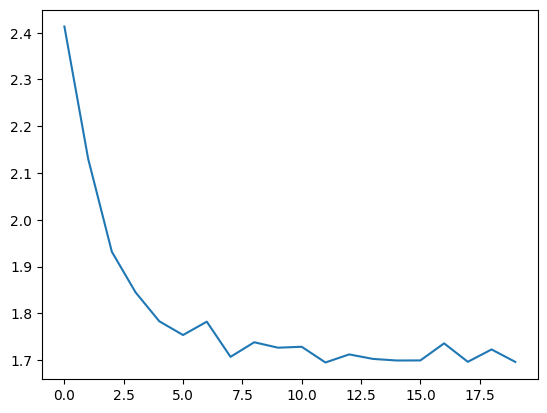

In [117]:
plt.figure()
plt.plot(all_losses)

<Axes: >

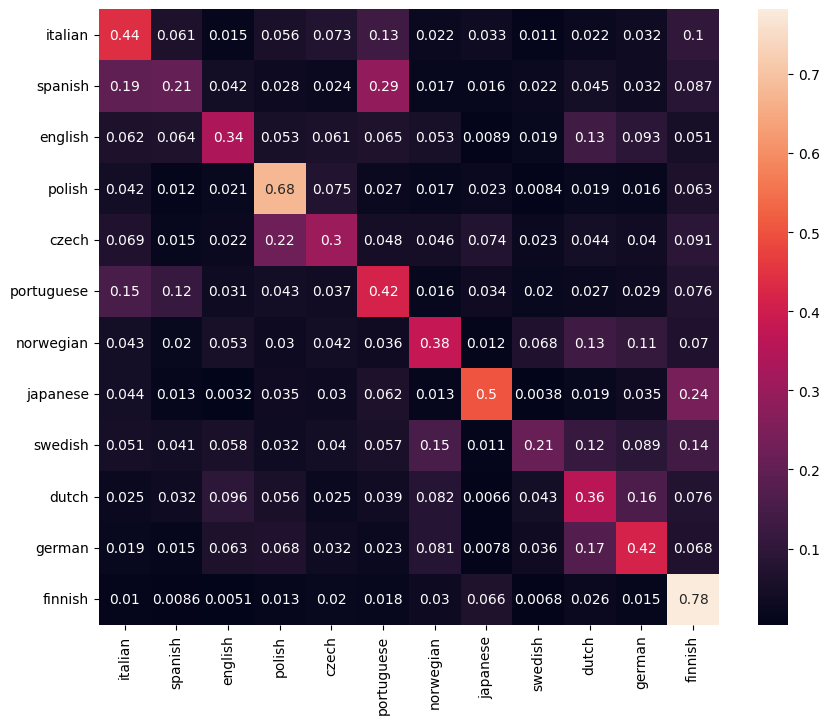

In [118]:
confusion = torch.zeros(n_langs, n_langs)
n_confs = 20000

def evaluate(rnn, device, word_tensor):
	hidden = rnn.initHidden().to(device)
	word_tensor = word_tensor.to(device)

	for i in range(word_tensor.size()[0]):
		out, hidden = rnn(word_tensor[i], hidden)

	return out

for i in range(n_confs):
	lang, word, lang_tensor, word_tensor = random_training_example()
	out = evaluate(rnn, device, word_tensor)
	guess, guess_i = lang_from_output(out)
	lang_i = langs.index(lang)
	confusion[lang_i][guess_i] += 1

# normalize rows of confusion matrix to get percentage
for i in range(n_langs):
	confusion[i] = confusion[i] / confusion[i].sum()

plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=confusion, yticklabels=langs, xticklabels=langs)

## Accepting user input

In [141]:
def predict(input_word, rnn, device, n_predictions=3):
	print(f'\n> {input_word}')

	with torch.no_grad():
		out: torch.Tensor = evaluate(rnn, device, word_to_one_hot_tensor(input_word))

		top_confidence, top_i = out.topk(n_predictions, 1, True)

		for i in range(n_predictions):
			conf = top_confidence[0][i].item()
			lang_i = top_i[0][i].item()
			print(f'({conf:2f}) {langs[lang_i]}')

In [153]:
print('From the dataset')
predict('sczescie', rnn, device)
predict('tanoshii', rnn, device)
predict('happiness', rnn, device)

print('\nNot a part of the dataset')
predict('lodowka', rnn, device)
predict('reizouko', rnn, device)
predict('kuhlschrank', rnn, device)

From the dataset

> sczescie
(-0.290565) polish
(-2.339154) czech
(-3.130197) italian

> tanoshii
(-0.748905) japanese
(-0.879691) finnish
(-2.837829) czech

> happiness
(-1.377018) english
(-1.710072) dutch
(-1.996341) german

Not a part of the dataset

> lodowka
(-0.200426) polish
(-2.527866) czech
(-3.870940) swedish

> reizouko
(-1.088443) polish
(-1.176184) japanese
(-2.231953) portuguese

> kuhlschrank
(-1.212326) norwegian
(-1.312453) dutch
(-2.040722) german
